<a href="https://colab.research.google.com/github/Strawberry404/sales-prediction/blob/main/salesprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM


In [ ]:
from tensorflow.keras.callbacks  import EarlyStopping , ModelCheckpoint


In [ ]:
store_sales = pd.read_csv("train.csv")

In [ ]:
store_sales.head(20)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check null **values**

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


dropping store and item colums

In [ ]:
store_sales = store_sales.drop(['store', 'item'], axis =1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date from object type to datetime data type

In [ ]:
store_sales['date']= pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting date to month period and the sm item number on each month

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

convert the resulting date column to timestamp data type

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


visualization


<function matplotlib.pyplot.show(close=None, block=None)>

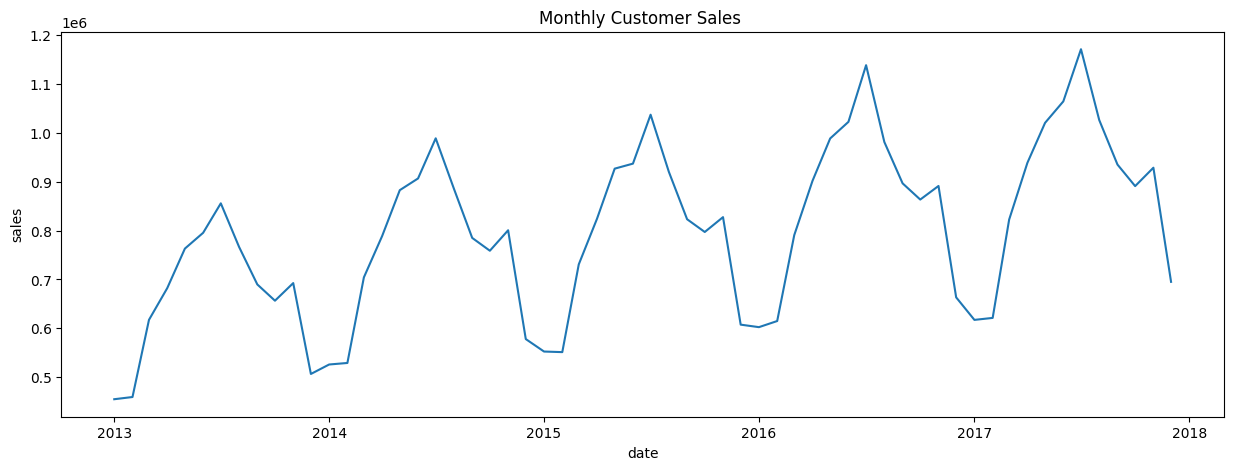

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("Monthly Customer Sales ")
plt.show

call the difference on the sales colums to make thee sales data stationery

In [ ]:
monthly_sales['sales_diff']= monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


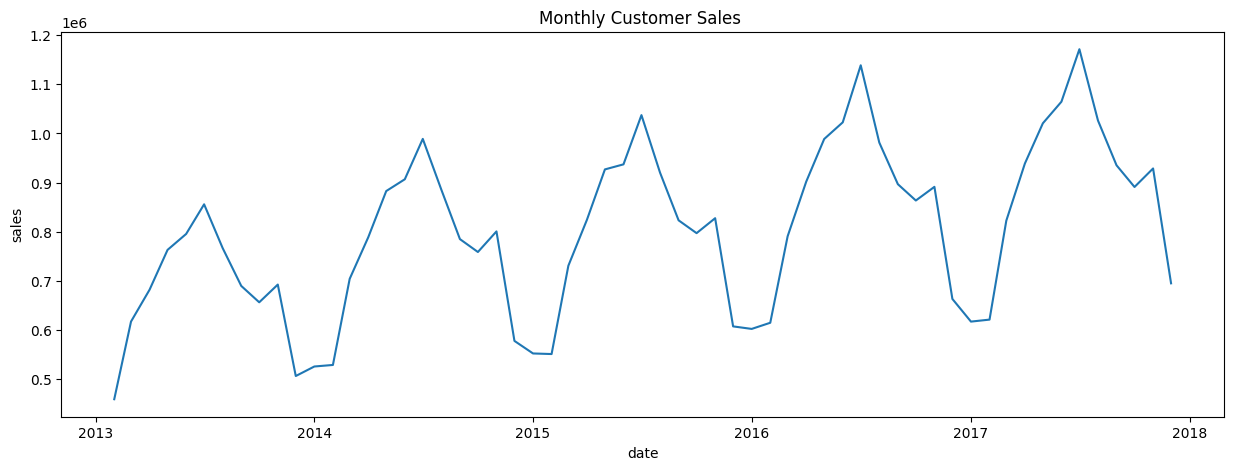

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("Monthly Customer Sales ")
plt.show ()

# **bold text** Train the model

dropping off sales and date

In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis =1)

preparing the supervised data

In [ ]:
for i in range(1,13):
  col_name = 'month' + str(i)
  supervised_data[col_name]= supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(20)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split data into train and test

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape :" , train_data.shape)
print("Test Data Shape :" , test_data.shape)

Train Data Shape : (35, 13)
Test Data Shape : (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train , y_train = train_data[:,1:] , train_data[:,0:1]
x_test , y_test = test_data[:,1:] , test_data[:,0:1]

y_train = y_train.ravel()
y_test = y_test.ravel()

print("X_train Shape:" ,x_train.shape)
print("Y_train Shape:" ,y_train.shape)
print("X_test Shape:", x_test.shape)
print("T_train Shape:", y_test.shape)

X_train Shape: (35, 12)
Y_train Shape: (35,)
X_test Shape: (12, 12)
T_train Shape: (12,)


Make prediction data frame to merge predicted sales prices of all trained alngs

In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)

predict_df = pd.DataFrame(sales_dates)



In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


create the linear regression model , and predicted output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train , y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
#this is a set matrix-contains the input featres of the test data , and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre , x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list=[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series= pd.Series(result_list , name ="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series , left_index =True , right_index=True)

In [ ]:
#sk is for evaluation
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'] , monthly_sales['sales'][-12:]))
lr_mas = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales['sales'][-12:])
lr_re = r2_score(predict_df["Linear Prediction"] , monthly_sales['sales'][-12:])

print("linear regression MSE ", lr_mse)
print("linear regression MAE", lr_mas)
print("linear regression R2 ", lr_re)


linear regression MSE  116719.57703032004
linear regression MAE 95980.2547628299
linear regression R2  0.5377514080121066


<function matplotlib.pyplot.show(close=None, block=None)>

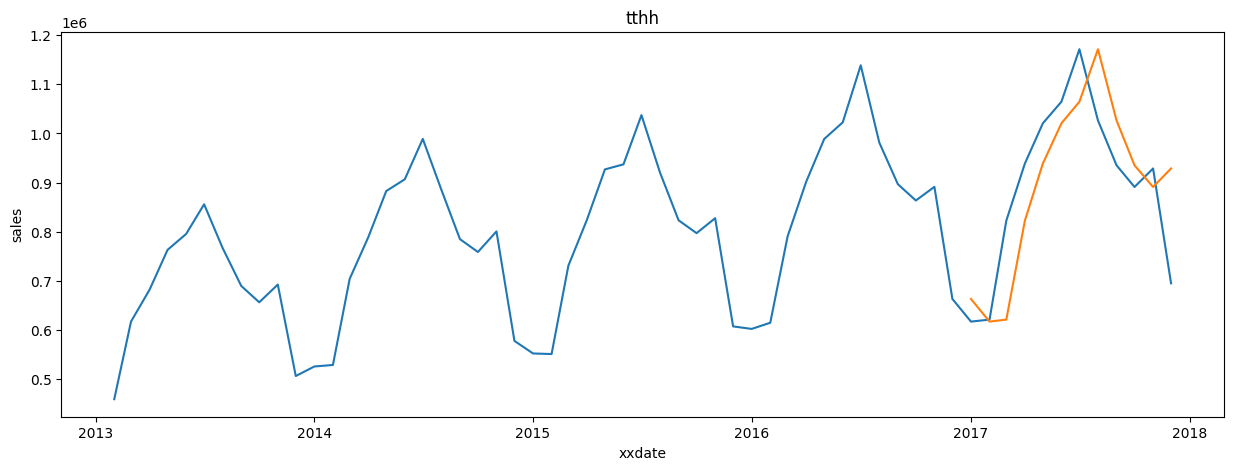

In [ ]:
plt.figure(figsize=(15,5 ))
plt.plot(monthly_sales['date'], monthly_sales['sales'])

plt.plot(predict_df['date'], predict_df['Linear Prediction'] )
plt.title('tthh')
plt.xlabel("xxdate")
plt.ylabel("sales")
plt.show

i did some mistake and i didn't get good predictions